# Milestone 1 : Data Collection, Exploration, and Preprocessing

## 1.1  We will start by importing the kitti dataset from kaggle to work on the project on the cloud instead of locally

In [1]:
ls /kaggle/input/*/


/kaggle/input/best-model/:
pytorch/

/kaggle/input/kitti-dataset/:
data_object_calib/    data_object_image_3/
data_object_image_2/  data_object_label_2/

/kaggle/input/kitti-dataset-yolo-format/:
classes.json  classes_with_dont_care.json  labels/  labels_with_dont_care/


## Imported Necessary Libraries 

In [2]:
# === Standard Library ===
import json
import os
import random
import shutil
import time
from collections import Counter
from pathlib import Path

# === Data Handling ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Image Processing & Augmentation ===
import cv2
import albumentations as A
from albumentations import Compose, HorizontalFlip, RandomCrop, Rotate


# === PyTorch & Torchvision ===
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# === Machine Learning Tools ===
from sklearn.model_selection import train_test_split

# === Progress Bar ===
from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
kaggle_dataset_path = Path('/kaggle/input/kitti-dataset')
label_dir = "/kaggle/input/kitti-dataset/data_object_label_2/training/label_2/"
image_dir = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/"
with open('/kaggle/input/kitti-dataset-yolo-format/classes.json','r') as f:
    classes = json.load(f)

classes

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7}

### Example image

In [4]:
def read_image_with_label(image_name):
    # Read the image
    image_path = os.path.join(image_dir, f"{image_name}.png") 
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Not Found: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Read the corresponding label file
    label_path = os.path.join(label_dir, f"{image_name}.txt")
    
    # Draw bounding boxes if label file exists
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                # KITTI format: [type truncation occlusion alpha x1 y1 x2 y2 h w l x y z rot_y]
                if len(data) >= 15:  # Ensure we have enough data
                    obj_type = data[0]
                    x1, y1, x2, y2 = float(data[4]), float(data[5]), float(data[6]), float(data[7])
                    
                    # Convert to integers for drawing
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    
                    # Draw rectangle
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Add label text
                    cv2.putText(image, obj_type, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print(f"Warning: No label file found at {label_path}")
    
    print(f"Image shape: {image.shape}")
    return image

Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)


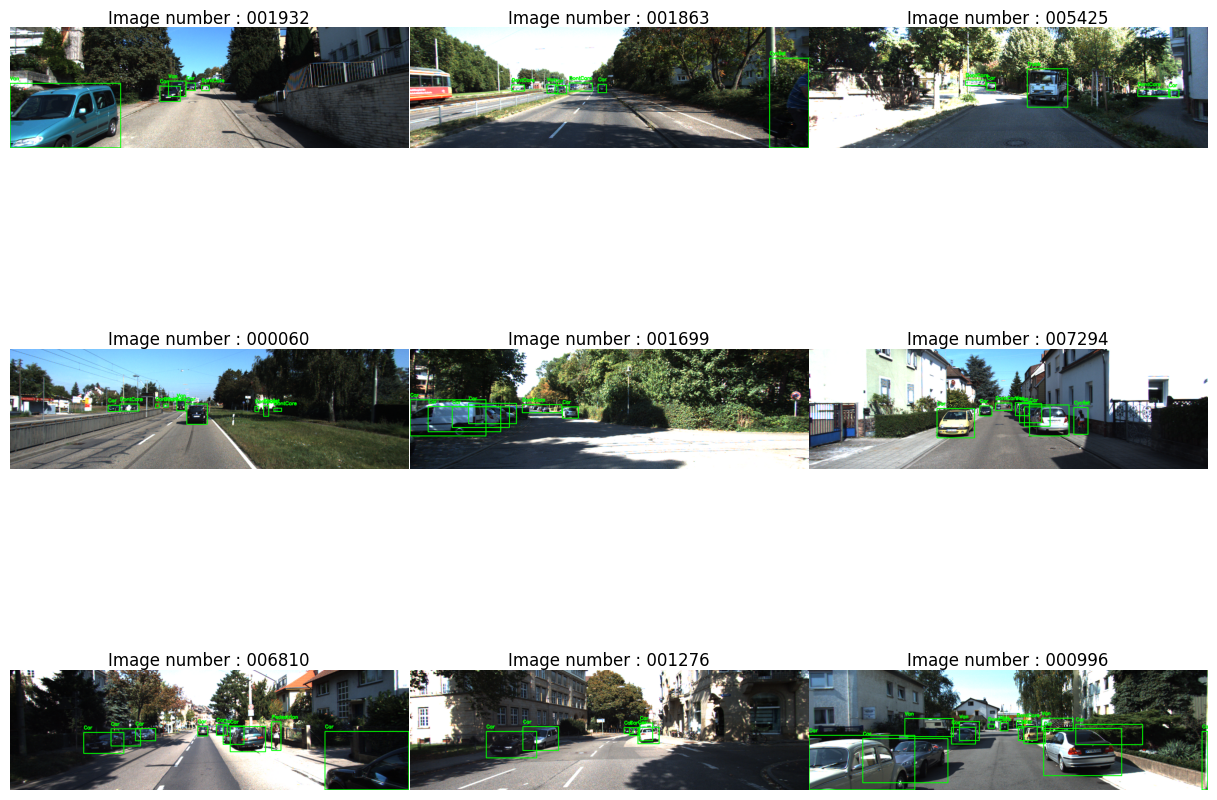

In [5]:
# Get random image names
img_files = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.png')]
selected = random.sample(img_files, min(9, len(img_files)))

# Create 3x3 plot with larger figure size
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Plot images with labels
for i, number in enumerate(selected):
    img = read_image_with_label(number)
    axes[i].imshow(img)
    axes[i].set_title(f"Image number : {number}", pad=2)  # Reduce title padding
    axes[i].axis('off')

# Maximize image space by reducing spacing and margins
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.05, hspace=0.1)

# Tight layout with minimal padding
plt.tight_layout(pad=0.1)
plt.show()

* Dataset has labelled bounding boxes for objects with different conditions 

## 1.2 Data Exploration 

### In order to know the distribution of objects we will count our class labels to understand the distrubtion

In [6]:
def label_counts_distribution():
    label_counts = Counter()
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), "r") as file:
            for line in file:
                class_name = line.split()[0] 
                label_counts[class_name] += 1 
    return label_counts

Distribution
Car: 28742
Van: 2914
DontCare: 11295
Misc: 973
Cyclist: 1627
Pedestrian: 4487
Truck: 1094
Tram: 511
Person_sitting: 222


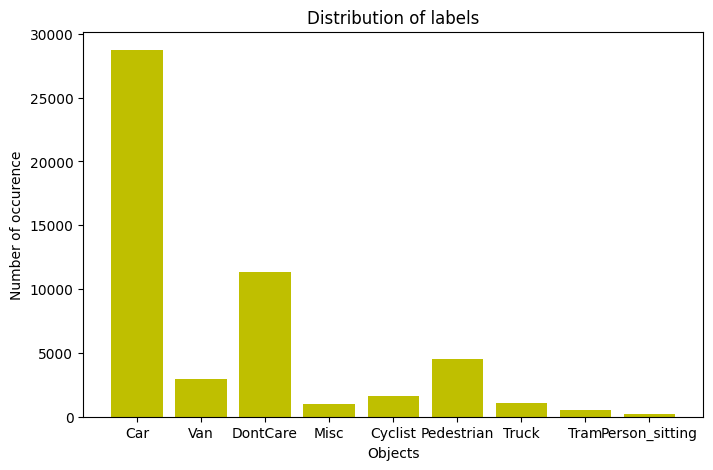

In [7]:
label_counts = label_counts_distribution()

print("Distribution")
for label, count in label_counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='y')
plt.xlabel("Objects")
plt.ylabel("Number of occurence")
plt.title("Distribution of labels")
plt.show()

The chart reveals significant class imbalance in the KITTI dataset, with cars dominating at approximately 29,000 instances, followed by DontCare annotations (~11,500) and pedestrians (~4,500). This imbalance reflects real-world urban driving scenarios but poses challenges for model training,  requiring class weighting or augmentation strategies to improve detection performance on small classes like Person_sitting and Tram.

### Data Quality investigations
* Loop over data to find different resolutions
* Check for biases 

In [8]:
# Image Resolution
def image_resolutions():
    resolutions = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path)
    
        if img is not None:
            resolutions.append(img.shape[:2])
    return np.array(resolutions)

In [ ]:
resolutions = image_resolutions()
unique_resolutions = np.unique(resolutions, axis=0)
print("Unique Image Resolutions:", unique_resolutions)

In [ ]:
def detect_box_positions():
    bbox_positions = {}
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), "r") as file:
            for line in file:
                parts = line.split()
                class_id = parts[0]  
                x_min, y_min, x_max, y_max = map(float, parts[4:8])  

                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2

                if class_id != "DontCare":
                    if class_id not in bbox_positions:
                        bbox_positions[class_id] = []
                
                    bbox_positions[class_id].append((x_center, y_center))
    return bbox_positions

bbox_positions = detect_box_positions()

plt.figure(figsize=(10, 6))
colors = ['yellow', 'red', 'gray', 'green', 'pink']

for i, (class_id, positions) in enumerate(bbox_positions.items()):
    positions = np.array(positions)
    plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, s=10, color=colors[i % len(colors)], label=f"Class {class_id}")

plt.xlabel("X Center")
plt.ylabel("Y Center")
plt.title("Distribution of Object Centers")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

This scatter plot shows where different objects appear in images. Cars (yellow dots) are most common and spread across the whole frame. Most objects appear in the middle and lower parts of images

### Detect Biases


In [13]:
def extract_bounding_boxes_and_tags(imageName):
    bounding_boxes = [] 
    environment_tags = []
    road_type = ""
    label_path = f"{label_dir}{imageName}.txt"
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            for line in file:
                values = line.split()
                if values[0] != 'DontCare':
                    x_min, y_min, x_max, y_max = map(float, values[4:8])
                    bounding_boxes.append((x_min, y_min, x_max, y_max))
                    environment_tags = values[-4:-1] 
                    road_type = values[-1] 
    else:
        print(f"Not Found: {label_path}")

    return bounding_boxes, environment_tags, road_type


## 1.3 Data Pre-Processing
### Data normalization and augmentation to prepare for yolo modelling

In [15]:
labels_dir='/kaggle/input/kitti-dataset-yolo-format/labels',
import os
import json
import random
import shutil
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def preprocess_kitti_dataset(
    kaggle_dataset_path,
    labels_dir,
    image_dir,
    output_dir,
    val_split=0.1,
    seed=42
):
    """
    Preprocess the KITTI dataset by creating original and augmented image batches.
    
    Args:
        kaggle_dataset_path (Path): Path to the Kaggle dataset root
        labels_dir (str): Path to YOLO format labels
        image_dir (str): Path to original images directory
        output_dir (str): Output directory path for processed dataset
        val_split (float): Validation split ratio (default: 0.2)
        seed (int): Random seed for reproducibility
    
    Returns:
        None
    """
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    # Create output directories
    output_path = Path(output_dir)
    train_dir = output_path / "train"
    val_dir = output_path / "val"
    
    # Create directories if they don't exist
    for directory in [output_path, train_dir, val_dir]:
        directory.mkdir(parents=True, exist_ok=True)
    
    # Get all image paths
    print("Finding image files...")
    image_paths = sorted([os.path.join(image_dir, f) for f in tqdm(os.listdir(image_dir), desc="Scanning images")
                         if f.endswith('.png')])
    
    # Get all label paths
    print("Finding label files...")
    label_paths = sorted([os.path.join(labels_dir, f) for f in tqdm(os.listdir(labels_dir), desc="Scanning labels")
                         if f.endswith('.txt')])
    
    # Match image and label files by base name (without extension)
    print("Matching image and label files...")
    image_label_pairs = []
    for img_path in tqdm(image_paths, desc="Matching files"):
        img_base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_dir, f"{img_base}.txt")
        
        if os.path.exists(label_path):
            image_label_pairs.append((img_path, label_path))
    
    print(f"Found {len(image_label_pairs)} matched image-label pairs")
    
    # Split into train and validation sets
    train_pairs, val_pairs = train_test_split(
        image_label_pairs, test_size=val_split, random_state=seed
    )
    
    print(f"Train set: {len(train_pairs)} pairs")
    print(f"Validation set: {len(val_pairs)} pairs")
    
    # Process the training and validation sets
    process_dataset_split(train_pairs, train_dir, augment=True)
    process_dataset_split(val_pairs, val_dir, augment=False)  # No augmentation for validation set
    
    print(f"Dataset processed successfully! Output saved to {output_dir}")


def process_dataset_split(image_label_pairs, output_dir, augment=True):
    """
    Process a dataset split (train or validation) by copying original images
    and creating augmented versions if specified.
    
    Args:
        image_label_pairs (list): List of (image_path, label_path) tuples
        output_dir (Path): Output directory path
        augment (bool): Whether to create augmented images for this split
    """
    print(f"\nProcessing {output_dir.name} set ({len(image_label_pairs)} images)...")
    progress_bar = tqdm(image_label_pairs, desc=f"Processing {output_dir.name}", unit="image")
    for idx, (img_path, label_path) in enumerate(progress_bar):
        # Get the base filename without extension
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        
        # Read the image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue
        
        # Read the label
        with open(label_path, 'r') as f:
            label_content = f.read()
        
        # Copy original image and label to output directory
        output_img_path = os.path.join(output_dir, f"{base_name}.png")
        output_label_path = os.path.join(output_dir, f"{base_name}.txt")
        
        # Save original image (with normalization)
        normalized_img = normalize_image(image)
        cv2.imwrite(output_img_path, normalized_img)
        
        # Save label
        with open(output_label_path, 'w') as f:
            f.write(label_content)
        
        # Create and save augmented image if specified
        if augment:
            aug_image, aug_labels = augment_image_and_labels(image, label_content)
            aug_img_path = os.path.join(output_dir, f"{base_name}_aug.png")
            # We'll use the same label file, so no need to create a new one
            cv2.imwrite(aug_img_path, aug_image)


def normalize_image(image):
    """
    Normalize an image.
    
    Args:
        image (numpy.ndarray): Input image
        
    Returns:
        numpy.ndarray: Normalized image
    """
    # Convert to float and normalize to 0-1 range
    normalized = image.astype(np.float32) / 255.0
    
    # Standardize
    mean = np.mean(normalized, axis=(0, 1))
    std = np.std(normalized, axis=(0, 1))
    normalized = (normalized - mean) / (std + 1e-7)
    
    # Convert back to uint8 range for saving
    normalized = (normalized * 127.5 + 127.5).astype(np.uint8)
    
    return normalized


def augment_image_and_labels(image, label_content):
    """
    Apply data augmentation to an image and adjust labels accordingly.
    
    Args:
        image (numpy.ndarray): Input image
        label_content (str): YOLO format label content
        
    Returns:
        tuple: (augmented_image, augmented_labels)
    """
    h, w = image.shape[:2]
    
    # Parse YOLO format labels
    labels = []
    for line in label_content.strip().split('\n'):
        if line.strip():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            labels.append([class_id, x_center, y_center, width, height])
    
    # Choose a random augmentation
    aug_type = random.choice(['flip', 'rotate', 'crop'])
    
    if aug_type == 'flip':
        # Horizontal flip
        augmented_image = cv2.flip(image, 1)
        # Adjust labels - for horizontal flip, x_center becomes 1 - x_center
        for label in labels:
            label[1] = 1.0 - label[1]  # Flip x_center
    
    elif aug_type == 'rotate':
        # Random small rotation (-15 to 15 degrees)
        angle = random.uniform(-15, 15)
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        augmented_image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        
        # We're using the same labels since small rotations won't affect YOLO coordinates significantly
        # For more precise label adjustment, a more complex transformation would be needed
    
    else:  # crop
        # Random crop (crop 80-100% of original size)
        crop_factor = random.uniform(0.8, 1.0)
        crop_w = int(w * crop_factor)
        crop_h = int(h * crop_factor)
        
        # Random crop position
        x1 = random.randint(0, w - crop_w)
        y1 = random.randint(0, h - crop_h)
        x2 = x1 + crop_w
        y2 = y1 + crop_h
        
        # Crop the image
        augmented_image = image[y1:y2, x1:x2]
        
        # Resize back to original size
        augmented_image = cv2.resize(augmented_image, (w, h))
        
        # We're using the same labels since we're resizing back to original dimensions
        # For more precise label adjustment, adjust YOLO coordinates based on crop parameters
    
    # Apply normalization to augmented image
    augmented_image = normalize_image(augmented_image)
    
    return augmented_image, label_content


if __name__ == "__main__":
    # Settings
    kaggle_dataset_path = Path('/kaggle/input/kitti-dataset')
    labels_dir = "/kaggle/input/kitti-dataset-yolo-format/labels"
    image_dir = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/"
    output_dir = "/kaggle/working/pre_processed_kitti"
    
    print("\n" + "="*50)
    print("KITTI Dataset Preprocessing")
    print("="*50)
    
    # Load class information
    print("Loading class information...")
    with open('/kaggle/input/kitti-dataset-yolo-format/classes.json', 'r') as f:
        classes = json.load(f)
    
    print(f"Classes: {classes}")
    print("="*50 + "\n")
    
    # Process the dataset with an overall timer
    from time import time
    start_time = time()
    
    # Process the dataset
    preprocess_kitti_dataset(
        kaggle_dataset_path=kaggle_dataset_path,
        labels_dir=labels_dir,
        image_dir=image_dir,
        output_dir=output_dir,
        val_split=0.1
    )


KITTI Dataset Preprocessing
Loading class information...
Classes: {'Car': 0, 'Pedestrian': 1, 'Van': 2, 'Cyclist': 3, 'Truck': 4, 'Misc': 5, 'Tram': 6, 'Person_sitting': 7}

Finding image files...


Scanning images: 100%|██████████| 7481/7481 [00:00<00:00, 908468.35it/s]


Finding label files...


Scanning labels: 100%|██████████| 7481/7481 [00:00<00:00, 1024708.15it/s]


Matching image and label files...


Matching files: 100%|██████████| 7481/7481 [00:16<00:00, 446.79it/s]


Found 7481 matched image-label pairs
Train set: 6732 pairs
Validation set: 749 pairs

Processing train set (6732 images)...


Processing train: 100%|██████████| 6732/6732 [17:25<00:00,  6.44image/s]



Processing val set (749 images)...


Processing val: 100%|██████████| 749/749 [01:11<00:00, 10.47image/s]

Dataset processed successfully! Output saved to /kaggle/working/pre_processed_kitti


Image shape: (375, 1242, 3)


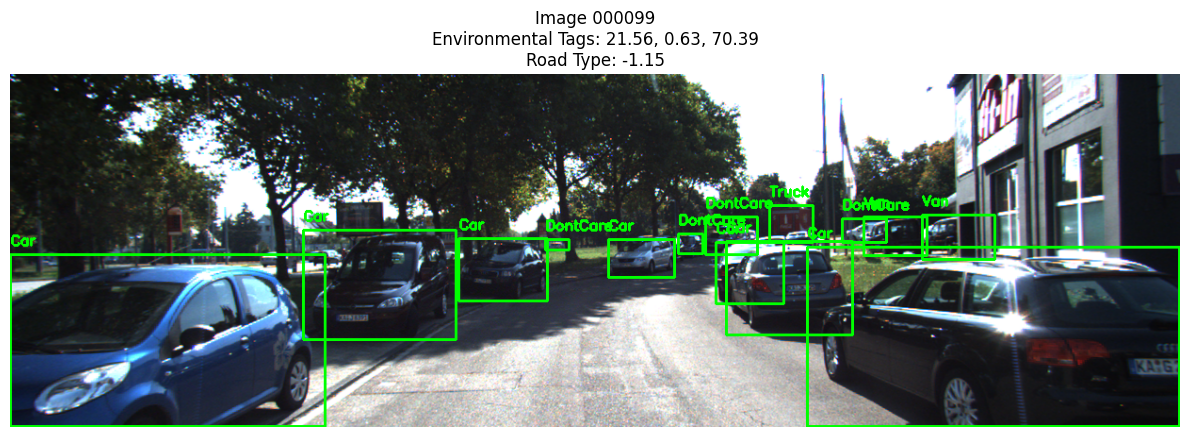

Analysis for image 000099:
Number of objects detected: 10
Environmental context: 21.56, 0.63, 70.39
Road type: -1.15


(array([[[ 44,  21,  24],
         [ 38,  32,   0],
         [ 35,  22,   0],
         ...,
         [ 57,  67,  79],
         [ 55,  66,  77],
         [ 55,  67,  78]],
 
        [[ 48,  25,  73],
         [ 47,  40, 209],
         [ 46, 102, 229],
         ...,
         [ 50,  67,  79],
         [ 51,  67,  78],
         [ 54,  67,  79]],
 
        [[ 19,  31,  51],
         [ 18,  26, 229],
         [ 38, 103, 255],
         ...,
         [ 51,  67,  80],
         [ 52,  68,  80],
         [ 54,  68,  80]],
 
        ...,
 
        [[  0, 255,   0],
         [  0, 255,   0],
         [ 12,  22,  48],
         ...,
         [ 12,  12,  11],
         [  0, 255,   0],
         [  0, 255,   0]],
 
        [[  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0],
         ...,
         [  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0]],
 
        [[  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0],
         ...,
         [  0, 255,   0],
  

In [14]:
def analyze_environmental_factors(image_name):
    # Get image with labels already drawn
    img = read_image_with_label(image_name)
    
    # Extract environmental information
    bounding_boxes, environment_tags, road_type = extract_bounding_boxes_and_tags(image_name)
    
    # Format environmental information for display
    environment_info = ", ".join(environment_tags) if environment_tags else "N/A"
    title_text = f"Image {image_name}\nEnvironmental Tags: {environment_info}\nRoad Type: {road_type}"
    
    # Display the image with environmental information
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title_text)
    plt.tight_layout()
    plt.show()
    
    # Simple analysis of environment
    print(f"Analysis for image {image_name}:")
    print(f"Number of objects detected: {len(bounding_boxes)}")
    print(f"Environmental context: {environment_info}")
    print(f"Road type: {road_type}")
    
    return img, bounding_boxes, environment_tags, road_type

analyze_environmental_factors("000099")

In [ ]:
print("hello")

# Milestone 2 : Object Detection Model Deployment


## 2.1 Model Selection & Loading
We will use the model YOlOv11 since we pre processed the image to be suitable size for it. It is also known for its good and fast performance

### Loading steps : 
1. First we will transform the processed data into YOLO format(normalized center x, center y, width, height, class index)
2. Save YOLO labels in a new directory structure compatible with Ultralytics
3. Model will be ready for training 

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")



 Using device: cuda
   GPU: Tesla T4
   Memory: 14.74 GB


# 2.2 Create YOLOv8 Data Config YAML
Describe your dataset for Ultralytics YOLOv8.

In [2]:
yaml_content = '''
# Dataset paths
train: /kaggle/working/pre_processed_kitti/train
val: /kaggle/working/pre_processed_kitti/val

# Number of classes
nc: 8

# Class names (explicit mapping)
names:
  0: Car
  1: Van
  2: Truck
  3: Pedestrian
  4: Person_sitting
  5: Cyclist
  6: Tram
  7: Misc
'''

with open('/kaggle/working/kitti_yolo.yaml', 'w') as f:
    f.write(yaml_content)
print(" YOLOv11 YAML file created successfully!")

 YOLOv11 YAML file created successfully!


# 2.3 Model Selection & Loading
Install Ultralytics and load YOLOv8 with COCO weights.

In [18]:
!pip install opencv-python

In [1]:
!pip install ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 whic

In [2]:

from ultralytics import YOLO
model = YOLO('/kaggle/input/yolo-detection/pytorch/default/1/yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [1]:

print("\n" + "="*70)
print("STARTING OPTIMIZED TRAINING")
print("="*70 + "\n")

train_results = model.train(
    # ==================== Dataset ====================
    data='/kaggle/working/kitti_yolo.yaml',
    
    # ==================== Training Duration ====================
    epochs=50,            
    patience=5,             
    
    # ==================== Image & Batch Size ====================
    imgsz=640,              
    batch=16,                
    
    # ==================== Optimizer Settings ====================
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    weight_decay=0.0005,
    warmup_epochs=3,
    
    # ==================== Data Augmentation ====================
    # Color augmentations
    hsv_h=0.015,          
    hsv_s=0.7,             
    hsv_v=0.4,             
    
    # Geometric augmentations
    degrees=10.0,         
    translate=0.1,         
    scale=0.5,             
    shear=2.0,              
    
    # Flip augmentations
    flipud=0.0,             
    fliplr=0.5,            
    
    # Advanced augmentations
    mosaic=1.0,
    mixup=0.05,
    copy_paste=0.1,
    # ==================== Performance ====================
    device=0,              
    workers=8,              
    amp=True,              
    
    # ==================== Saving & Logging ====================
    project='yolov8s-kitti',
    name='run',             
    exist_ok=True,         
    save=True,             
    save_period=10,         
    
    # ==================== Validation ====================
             
    
    val=True,
    plots=True,
    close_mosaic=10,
    seed=42
    
)

print("\n" + "="*70)
print("✓ TRAINING COMPLETED!")
print("="*70)

# ==================== Print Results ====================
print("\nTraining Results:")
print(f"  • Best mAP50:    {train_results.results_dict.get('metrics/mAP50(B)', 0):.4f}")
print(f"  • Best mAP50-95: {train_results.results_dict.get('metrics/mAP50-95(B)', 0):.4f}")
print(f"  • Final Loss:    {train_results.results_dict.get('train/box_loss', 0):.4f}")

print("\nModel saved at:")
print(f"  • Best:  {train_results.save_dir}/weights/best.pt")
print(f"  • Last:  {train_results.save_dir}/weights/last.pt")


# 2.5 Model Evaluation (mAP, IoU, FPS)
Evaluate the trained model on the validation set.

In [ ]:
from ultralytics.utils.plotting import plot_results
import os

# Path to the training run directory
run_dir = 'runs/train/yolov8s-kitti'  # Adjust based on your project name and latest run

# Plot the results
plot_results(file=os.path.join(run_dir, 'results.csv'))  # Ensure results.csv exists

# 2.6 Visualize Predictions
Show predictions on a few validation images.


0: 576x576 1 Van, 2 Pedestrians, 9.6ms
1: 576x576 2 Cars, 9.6ms
2: 576x576 (no detections), 9.6ms
3: 576x576 (no detections), 9.6ms
4: 576x576 (no detections), 9.6ms
5: 576x576 2 Cars, 3 Vans, 9.6ms
6: 576x576 1 Car, 9.6ms
7: 576x576 2 Cars, 9.6ms
8: 576x576 8 Cars, 1 Truck, 9.6ms
9: 576x576 1 Van, 9.6ms
10: 576x576 1 Car, 9.6ms
11: 576x576 (no detections), 9.6ms
12: 576x576 2 Cars, 9.6ms
13: 576x576 1 Van, 1 Pedestrian, 9.6ms
14: 576x576 3 Cars, 1 Truck, 9.6ms
15: 576x576 6 Cars, 9.6ms
16: 576x576 (no detections), 9.6ms
17: 576x576 (no detections), 9.6ms
18: 576x576 3 Cars, 9.6ms
19: 576x576 1 Car, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 576)
Results saved to /kaggle/working/runs/kitti_results/predictions


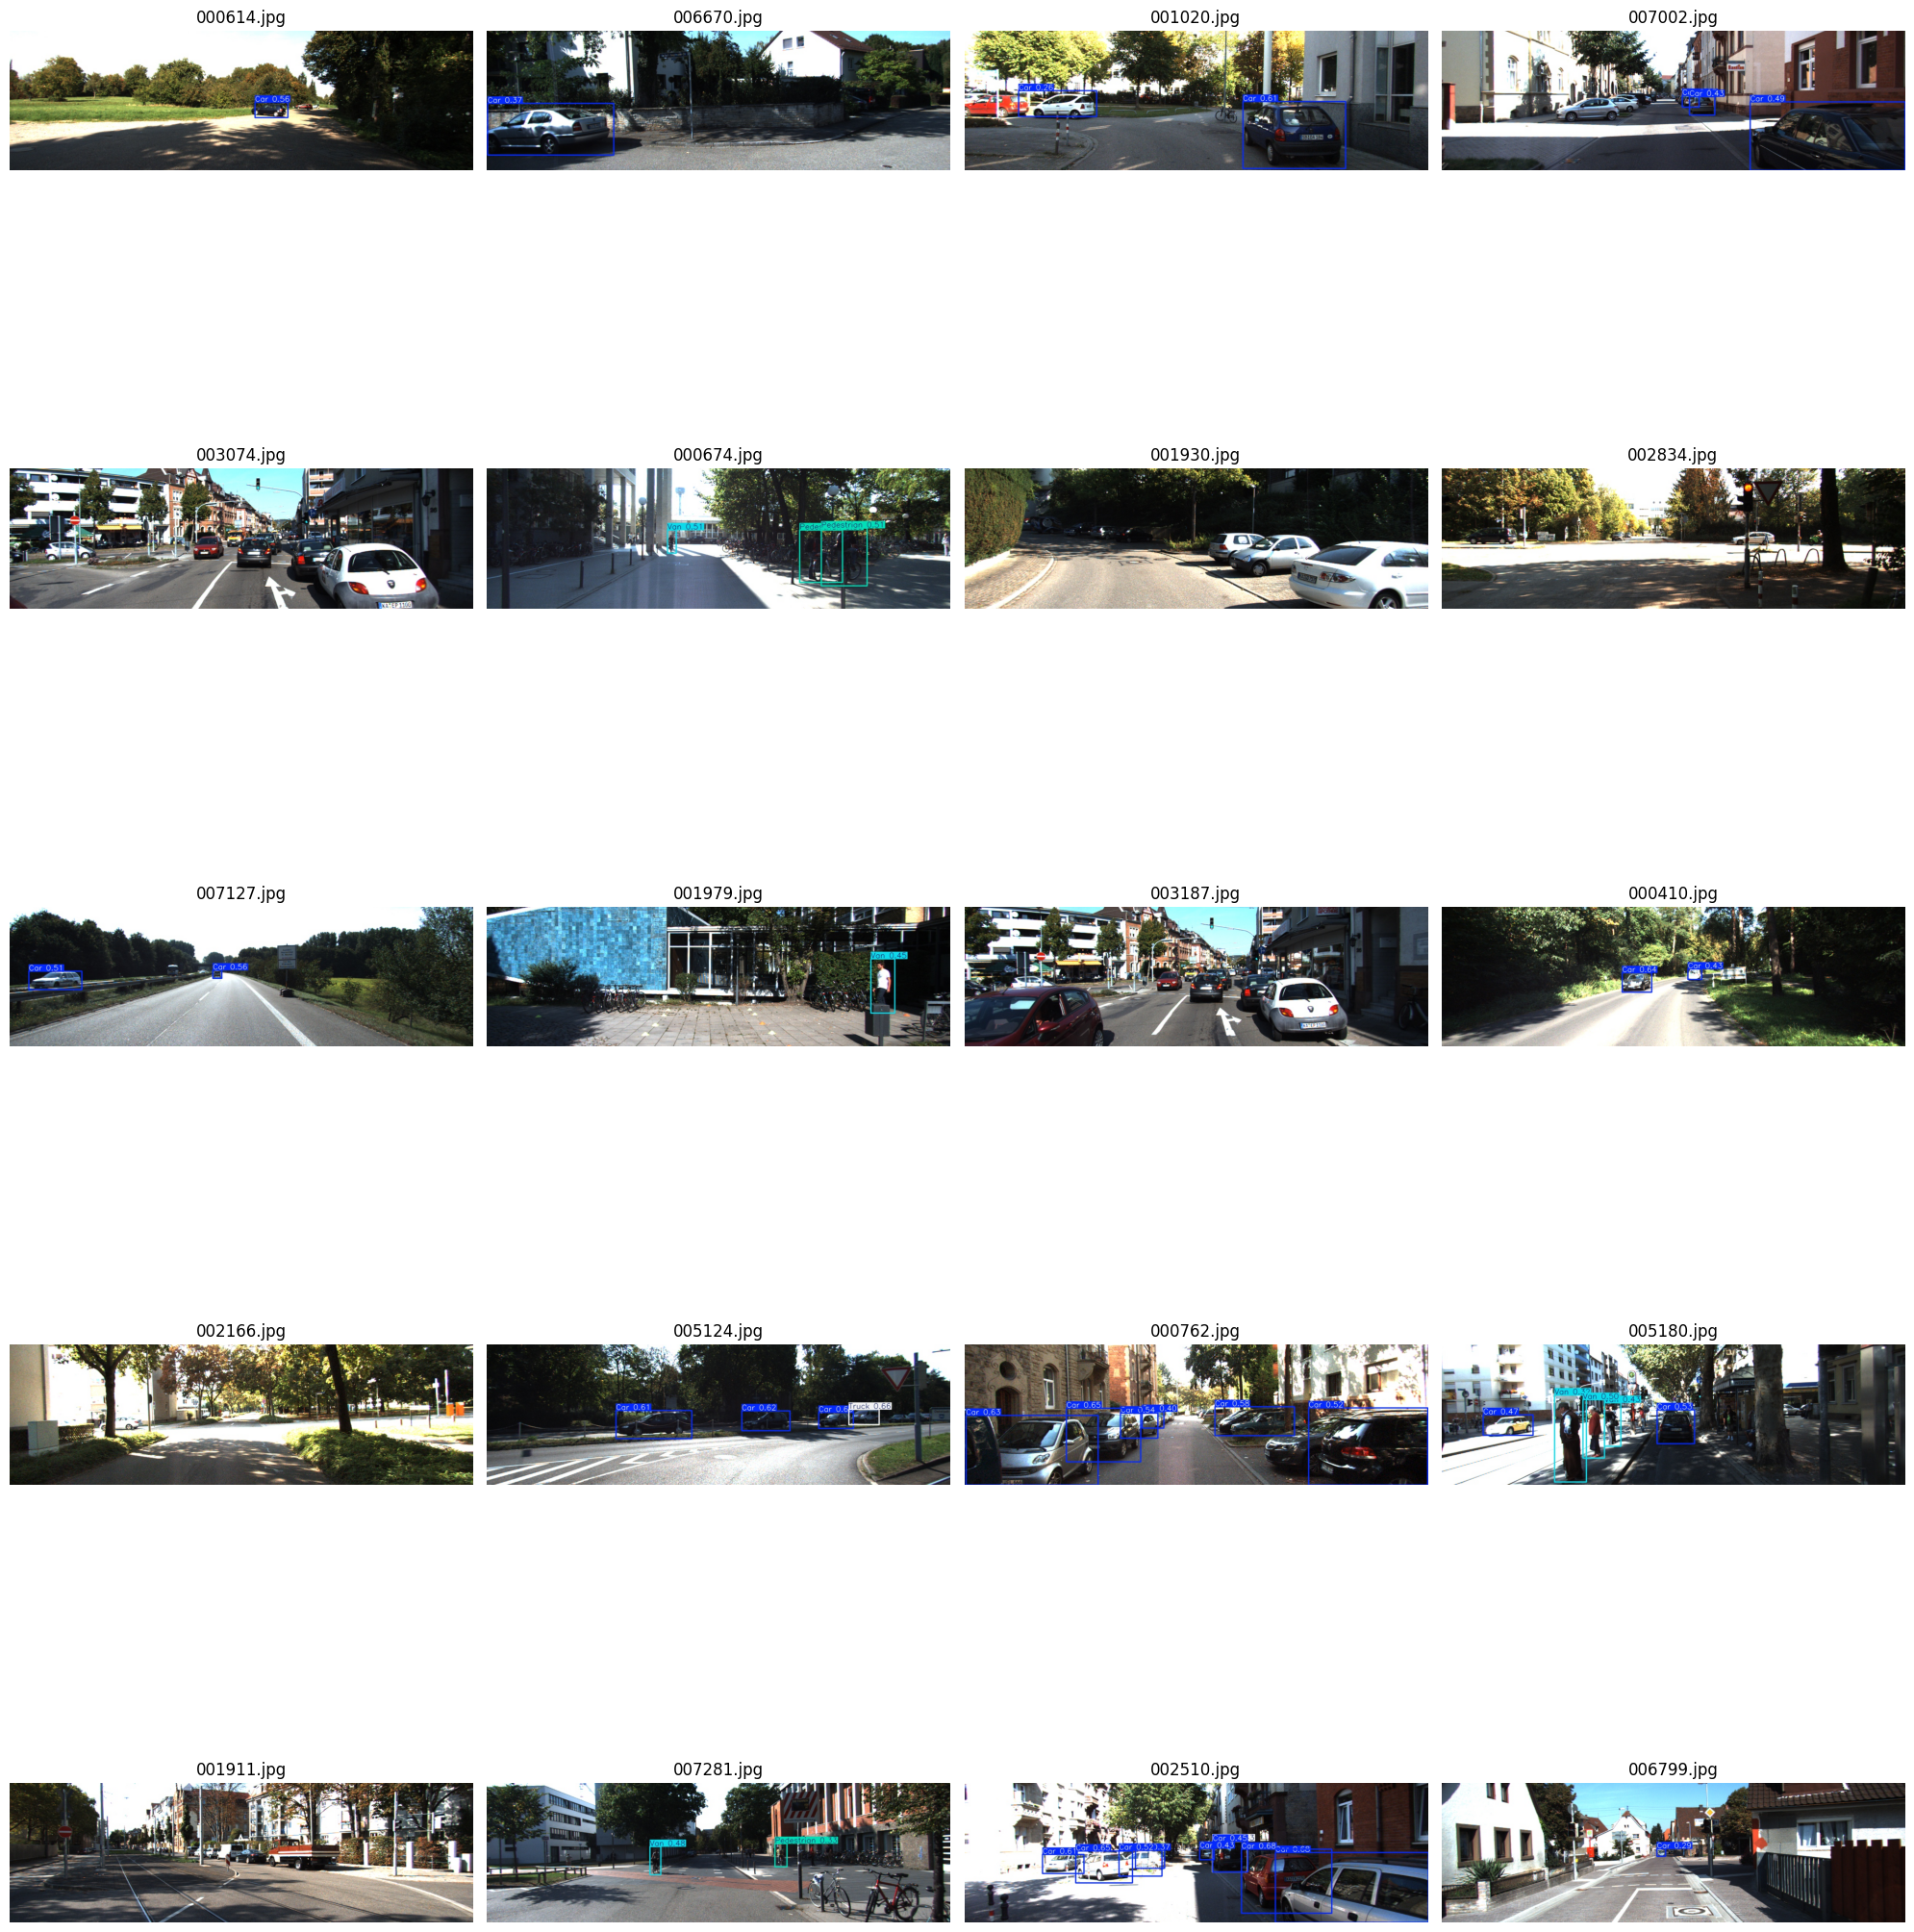

In [3]:
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt


# Dataset path
test_image_dir = Path('/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2')
image_paths = list(test_image_dir.glob('*.png'))

# Select 20 unique random images
selected_images = np.random.choice(image_paths, size=20, replace=False)

# Run predictions
preds = model.predict(
    source=[str(p) for p in selected_images],
    save=True,
    project='runs/kitti_results',
    name='predictions',
    exist_ok=True   # prevents overwrite errors
)

# Prediction directory
pred_dir = Path('runs/kitti_results/predictions')

# Filter valid image extensions
valid_imgs = [p for p in pred_dir.glob('*') if p.suffix.lower() in ['.png', '.jpg', '.jpeg']]

# Plot function (auto layout)
def plot_images(images, max_cols=4):
    num_images = len(images)
    cols = min(max_cols, num_images)
    rows = (num_images // cols) + (num_images % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for ax in axes.flat:
        ax.axis('off')

    for ax, img_path in zip(axes.flat, images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.name)

    plt.tight_layout()
    plt.show()

# Show results
plot_images(valid_imgs)


# Milestone 3 : Model Deployment and Testing